# What is Pneumonia?
Pneumonia is an inflammation of the lungs, usually caused by an infection. The air sacs (alveoli) in the lungs fill up with fluid or pus, making it difficult to breathe.

Pneumonia can be caused by a variety of microorganisms, including bacteria, viruses, and fungi. The most common cause of bacterial pneumonia is Streptococcus pneumoniae. Viral pneumonia is often caused by the influenza virus (flu) or respiratory syncytial virus (RSV). Fungal pneumonia is rare in healthy people, but it can occur in people with weakened immune systems.

Pneumonia can be mild or severe. Mild pneumonia can often be treated at home with rest, over-the-counter medications, and fluids. Severe pneumonia may require hospitalization, especially for young children, older adults, and people with other health conditions.

#### Symptoms of pneumonia

The most common symptoms of pneumonia include:

- Cough, which may produce green, yellow, or bloody mucus
- Fever
- Chest pain
- Shortness of breath
- Chills
- Fatigue
- Muscle aches
- Loss of appetite
- Headache

#### Treatment for pneumonia

Treatment for pneumonia depends on the type of infection. Bacterial pneumonia is treated with antibiotics. Viral pneumonia usually goes away on its own, but antiviral medications may be used in some cases. Fungal pneumonia is treated with antifungal medications.

In addition to medication, people with pneumonia may also need to:

- Get plenty of rest
- Drink plenty of fluids
- Take over-the-counter medications to relieve fever and pain
- Use a humidifier or take a hot shower to help loosen mucus

#### Prevention of pneumonia

There are a number of things you can do to help prevent pneumonia, including:

- Get a flu shot every year
- Get a pneumococcal vaccine, especially if you are over 65 or have a - - chronic health condition
- Wash your hands often with soap and water
- Avoid smoking
- Avoid close contact with people who are sick

# Data Preparation and Loading

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download the dataset zip file
!gdown --id 1-0aqzy_fBNWgdMkz0PS3LIz8flK44GkP

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-0aqzy_fBNWgdMkz0PS3LIz8flK44GkP
To: /content/split_data_balanced.zip
100% 6.53G/6.53G [01:47<00:00, 60.8MB/s]


In [4]:
# Define paths
zip_path = '/content/split_data_balanced.zip' # Path to the downloaded zip file
extract_path = '/content/dataset/' # Destination folder for extracted files

# Extract the contents of the zip file
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Define the directory path where the data is located
data_dir = "/content/dataset/split_data_balanced"

# Print the list of files and directories in the specified directory
print(os.listdir(data_dir))

# List the classes or categories within the 'train' subdirectory
classes = os.listdir(data_dir + "/train")

# Print the total number of classes
print(len(classes))

# Store the total number of classes in the variable 'num_cls'
num_cls = len(classes)

['train', 'test']
2


In [6]:
# Define transformations for training images
train_transformations = transforms.Compose([
    transforms.Resize((255, 255)),  # Resize images to 255x255 pixels
    transforms.ToTensor()  # Convert images to tensors
])

# Define transformations for testing images
test_transformations = transforms.Compose([
    transforms.Resize((255, 255)),  # Resize images to 255x255 pixels
    transforms.ToTensor()  # Convert images to tensors
])

In [7]:
# Load the training dataset with specified transformations
training_dataset = ImageFolder(data_dir+'/train', transform=train_transformations)

# Load the testing dataset with specified transformations
testing_dataset = ImageFolder(data_dir+'/test', transform=test_transformations)

We have preprocessed the dataset by first downloading and extracting it. Then, we defined transformation pipelines for both training and testing images, which included resizing them to 255x255 pixels and converting them into tensors. Subsequently, we loaded the preprocessed data using the ImageFolder dataset class, ensuring that these transformations were applied. This prepares the data for further processing and training of machine learning models.

In [8]:
print(training_dataset.classes)
print(len(training_dataset.classes))

['normal', 'pneumonia']
2


The dataset consists of two classes: 'normal' and 'pneumonia'.

In [9]:
def show_example(img, label):
    """
    Displays an example image from the dataset along with its label.

    Args:
        img (Tensor): The image tensor.
        label (int): The label corresponding to the image.
    """
    print('Label: ', training_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  normal (0)


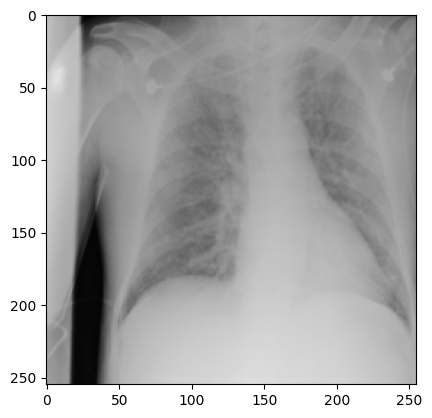

In [10]:
# Display an example image from the dataset
show_example(*training_dataset[700])

In [11]:
# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Define the size of the validation set
val_size = 250

# Calculate the size of the training set
train_size = len(training_dataset) - val_size

# Randomly split the training dataset into training and validation sets
train_ds, val_ds = random_split(training_dataset, [train_size, val_size])

# Print the lengths of the training and validation sets
print(len(train_ds), len(val_ds))

15100 250


We've set a random seed to ensure reproducibility in our experiments. The validation set size has been defined as 250 samples. The remaining samples are allocated for the training set, which amounts to 15,100 samples. These two sets will be used for training and evaluating the model, respectively.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


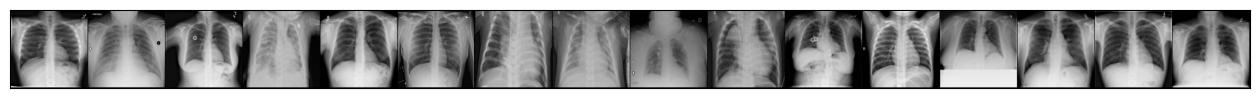

In [15]:
from torch.utils.data.dataloader import DataLoader

# Set the batch size for training and validation dataloaders
batch_size = 16

# Create DataLoader for the training set
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Create DataLoader for the validation set
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

from torchvision.utils import make_grid

def show_batch(dl):
    """
    Display a batch of images from a DataLoader.

    Args:
        dl (DataLoader): The DataLoader containing the images.
    """
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

# Display a batch of images from the training DataLoader
show_batch(train_dl)

In this code, we're preparing a dataset for training a deep learning model.

1. We set a random seed (42) to ensure reproducibility of results across different runs.

2. We defined the size of the validation set to be 250 samples.

3. We calculated the size of the training set as the total number of samples minus the validation set size.

4. Next, we randomly split the training dataset into training (train_ds) and validation (val_ds) sets using the specified sizes.

5. Then, we set the batch size to 16 for both training and validation data loaders (train_dl and val_dl). The batch size determines how many samples are processed together in each iteration of training.

6. We also enabled shuffling of the training data (shuffle=True) to ensure that the model doesn't learn any sequence patterns.

7. Additionally, we specified num_workers=4 for both loaders. This enables multi-threading to load data in parallel, which can speed up the training process.

8. Finally, we defined a function show_batch to visualize a batch of images from the DataLoader.

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [16]:
# Wrapping the training DataLoader with DeviceDataLoader
train_dl = DeviceDataLoader(train_dl, device)

# Wrapping the validation DataLoader with DeviceDataLoader
val_dl = DeviceDataLoader(val_dl, device)

# Define the models

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
def accuracy(outputs, labels):
    """
    Calculate the accuracy of model predictions.

    Args:
        outputs (Tensor): Predicted probabilities from the model.
        labels (Tensor): True labels.

    Returns:
        Tensor: Accuracy as a scalar value.
    """
    _, preds = torch.max(outputs, dim=1)  # Get the predicted classes
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))  # Calculate and return accuracy


In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        """
        Perform one step of training on the batch of data.

        Args:
            batch (tuple): A tuple containing the input images and their labels.

        Returns:
            Tensor: Loss for the current step.
        """
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        """
        Perform one step of validation on the batch of data.

        Args:
            batch (tuple): A tuple containing the input images and their labels.

        Returns:
            dict: Dictionary containing validation loss and accuracy.
        """
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        """
        Calculate the average loss and accuracy over a validation epoch.

        Args:
            outputs (list): List of dictionaries containing validation losses and accuracies.

        Returns:
            dict: Dictionary containing average validation loss and accuracy.
        """
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        """
        Print and log the epoch's training and validation results.

        Args:
            epoch (int): The current epoch number.
            result (dict): Dictionary containing training and validation results.
        """
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    """
    Evaluate the model on the validation set.

    Args:
        model (nn.Module): The neural network model.
        val_loader (DataLoader): DataLoader for the validation set.

    Returns:
        dict: Dictionary containing average validation loss and accuracy.
    """
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """
    Train the model for a specified number of epochs.

    Args:
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        opt_func (function, optional): The optimizer function. Defaults to torch.optim.SGD.

    Returns:
        list: List of dictionaries containing training and validation results for each epoch.
    """
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()

        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [22]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return training_dataset.classes[preds[0].item()]

In [23]:
def conv_block(in_channels, out_channels, pool=False):
    """
    Create a convolutional block with optional pooling.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        pool (bool, optional): Whether to include max pooling. Default is False.

    Returns:
        nn.Sequential: A sequential container of convolutional layers.

    """
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]

    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Define convolutional blocks
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        # Define the classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(512*15*15, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)

        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)

        out = self.res2(out) + out

        out = self.classifier(out)
        return out


In [24]:
import math

def conv_bch_norm(inp, oup, stride):
    """
    Create a convolutional block with batch normalization and ReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the convolution.

    Returns:
        nn.Sequential: A sequential container of layers.

    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_dim1_bch_norm(inp, oup):
    """
    Create a 1x1 convolutional block with batch normalization and ReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.

    Returns:
        nn.Sequential: A sequential container of layers.

    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def give_division_number(x, divisible_by=8):
    """
    Calculate the smallest multiple of 'divisible_by' that is greater than 'x'.

    Args:
        x (int): Input number.
        divisible_by (int, optional): Divisor. Default is 8.

    Returns:
        int: Result of the calculation.

    """
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        """
        Initialize an Inverted Residual Block.

        Args:
            inp (int): Number of input channels.
            oup (int): Number of output channels.
            stride (int): Stride for the convolution.
            expand_ratio (float): Expansion factor for the hidden dimension.

        """
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        dimension_size_hidden = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup
        if expand_ratio == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(dimension_size_hidden, dimension_size_hidden, 3, stride, 1, groups=dimension_size_hidden, bias=False),
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),
                nn.Conv2d(dimension_size_hidden, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, dimension_size_hidden, 1, 1, 0, bias=False),
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),
                nn.Conv2d(dimension_size_hidden, dimension_size_hidden, 3, stride, 1, groups=dimension_size_hidden, bias=False),
                nn.BatchNorm2d(dimension_size_hidden),
                nn.ReLU6(inplace=True),
                nn.Conv2d(dimension_size_hidden, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, inv_object):
        if self.use_res_connect:
            return inv_object + self.conv(inv_object)
        else:
            return self.conv(inv_object)

In [25]:
import math

class MobileNetV2(ImageClassificationBase):
    def __init__(self, num_of_class=num_cls, in_size_dim=224, mult_width_config=1.):
        super(MobileNetV2, self).__init__()

        # Alias for the InvertedResidual block
        blk = InvertedResidual
        in_ch = 32
        final_ch = 1280

        # Configuration for inverted residuals
        config_inversions_congestion = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 1, 2],
            [6, 96, 2, 1],
            [6, 160, 2, 2],
            [6, 320, 1, 1],
        ]

        # Ensure the input size is divisible by 32
        assert in_size_dim % 32 == 0

        # Compute the final channel count
        self.last_channel = give_division_number(final_ch * mult_width_config) if mult_width_config > 1.0 else final_ch

        # Define initial convolutional block
        self.features = [conv_bch_norm(3, in_ch, 2)]

        # Build the rest of the model
        for t, c, n, s in config_inversions_congestion:
            out_ch = give_division_number(c * mult_width_config) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(blk(in_ch, out_ch, s, expand_ratio=t))
                else:
                    self.features.append(blk(in_ch, out_ch, 1, expand_ratio=t))
                in_ch = out_ch

        # Add final convolutional block
        self.features.append(conv_dim1_bch_norm(in_ch, self.last_channel))
        self.features = nn.Sequential(*self.features)

        # Define the classifier (fully connected layer)
        self.classifier = nn.Linear(self.last_channel, num_of_class)

        # Initialize the weights of the model
        self._initialize_weights()

    def _initialize_weights(self):
        for each_module in self.modules():
            if isinstance(each_module, nn.Conv2d):
                p = each_module.kernel_size[0] * each_module.kernel_size[1] * each_module.out_channels
                each_module.weight.data.normal_(0, math.sqrt(2. / p))
                if each_module.bias is not None:
                    each_module.bias.data.zero_()
            elif isinstance(each_module, nn.BatchNorm2d):
                each_module.weight.data.fill_(1)
                each_module.bias.data.zero_()
            elif isinstance(each_module, nn.Linear):
                p = each_module.weight.size(1)
                each_module.weight.data.normal_(0, 0.01)
                each_module.bias.data.zero_()

    def forward(self, mn_object):
        # Apply feature extraction layers
        mn_object = self.features(mn_object.to(device))

        # Global average pooling
        mn_object = mn_object.mean(3).mean(2)

        # Apply the classifier (fully connected layer)
        mn_object = self.classifier(mn_object)

        return mn_object


## MobilenetV2 model

In [26]:
model_mobilenet = to_device(MobileNetV2(mult_width_config=1, num_of_class=num_cls), device)
model_mobilenet

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [29]:
history=[evaluate(model_mobilenet, val_dl)]
history

[{'val_loss': 0.6931474208831787, 'val_acc': 0.46484375}]

In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
history_mob = fit(num_epochs, lr, model_mobilenet, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4397, val_loss: 0.4131, val_acc: 0.8275
Epoch [1], train_loss: 0.3701, val_loss: 0.3872, val_acc: 0.8422
Epoch [2], train_loss: 0.3428, val_loss: 0.4722, val_acc: 0.8098
Epoch [3], train_loss: 0.3210, val_loss: 0.2911, val_acc: 0.8723
Epoch [4], train_loss: 0.3067, val_loss: 0.3154, val_acc: 0.8897
Epoch [5], train_loss: 0.2965, val_loss: 0.2836, val_acc: 0.8936
Epoch [6], train_loss: 0.2811, val_loss: 0.3616, val_acc: 0.8362
Epoch [7], train_loss: 0.2770, val_loss: 0.3127, val_acc: 0.8606
Epoch [8], train_loss: 0.2663, val_loss: 0.3309, val_acc: 0.8684
Epoch [9], train_loss: 0.2527, val_loss: 0.3159, val_acc: 0.8441


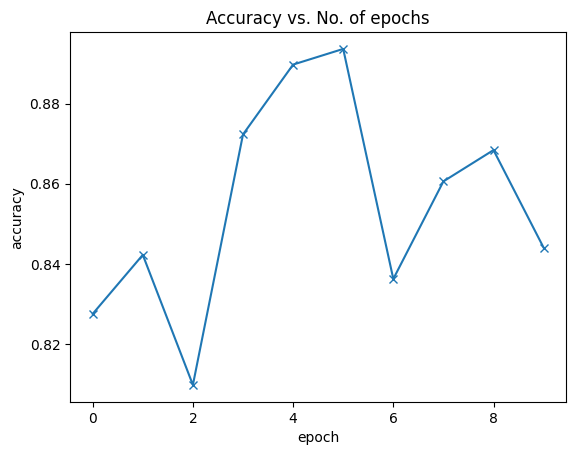

In [32]:
plot_accuracies(history_mob)

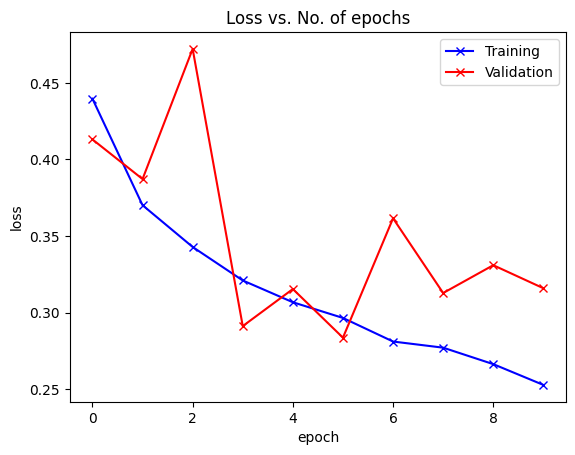

In [33]:
plot_losses(history_mob)

Label: normal , Predicted: normal


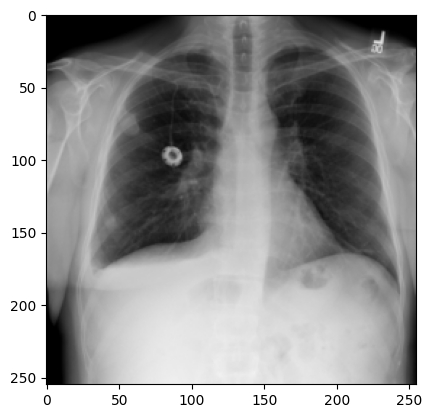

In [34]:
img, label = testing_dataset[76]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_mobilenet))

Label: normal , Predicted: normal


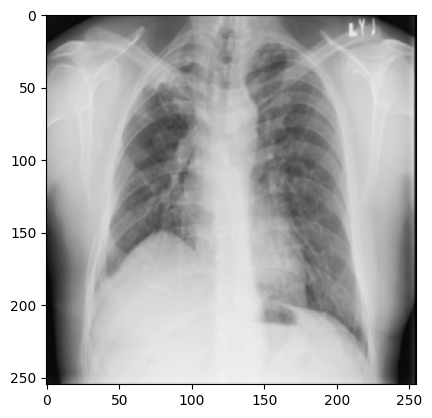

In [35]:
img, label = testing_dataset[160]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_mobilenet))

In [38]:
# Define a file path where you want to save the model
model_path = '/content/drive/MyDrive/mobilenet_model.pth'

# Save the model
torch.save(model_mobilenet.state_dict(), model_path)